In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Lambda
import numpy as np

# verify if GPU is available
print(tf.test.is_gpu_available())

# set memory growth to true
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Setting memory growth to True for GPU: ", physical_devices[0])
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# dont display much info of tensorflow
tf.get_logger().setLevel('ERROR')


2023-12-29 18:52:52.072204: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-29 18:52:52.126052: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 18:52:52.126081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 18:52:52.128176: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-29 18:52:52.138454: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2023-12-29 18:52:56.387467: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-29 18:52:56.459657: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-29 18:52:56.459825: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:

# Load data
manta_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
y = np.load(y_path)
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
print("y shape: ", y.shape) # laser power and velocity

#feats = np.load(feats_path)
#print("feats shape: ", feats.shape)
y = y[:, 0] # only use laser power
print("y shape: ", y.shape)

# normalize y
y = y / np.max(y)

manta shape:  (9587, 320, 320)
xiris shape:  (9587, 320, 320)
y shape:  (9587, 2)
y shape:  (9587,)


In [3]:
# unique values in y
y_unique = np.unique(y)
print("unique values in y: ", y_unique)

# encode y as integers based on unique values
y_encoded = np.zeros(y.shape)
for i in range(len(y_unique)):
    y_encoded[y == y_unique[i]] = i
print("y encoded: ", y_encoded)
# change to int
y_encoded = y_encoded.astype(int)

# print typr of y_encoded
print("y encoded type: ", type(y_encoded[0]))

unique values in y:  [0.18181818 0.45454545 0.72727273 1.        ]
y encoded:  [0. 0. 0. ... 3. 3. 3.]
y encoded type:  <class 'numpy.int64'>


In [4]:
# crate pairs
def create_pairs(manta, xiris, y_encoded):
    # set seed
    np.random.seed(42)
        
    pairs = []
    labels = []
    
    # Getting the indices of each class
    numclasses = len(np.unique(y_encoded))
    idx = [np.where(y_encoded==i)[0] for i in range(numclasses)]

    for idxA in range(len(y_encoded)):
        # grab the current image and label belonging to the current iteration
        currentImage = manta[idxA]
        label = y_encoded[idxA]

        # randomly pick an image that belongs to the same class label
        idxB = np.random.choice(idx[label])
        posImage = xiris[idxB]

        # prepare a positive pair and update the images and labels lists, respectively
        pairs.append([currentImage, posImage])
        labels.append([1])

        # grab the indices for each of the class labels not equal to the current label
        negIdx = np.where(y_encoded != label)[0]
        
        # check if the indices in negIdx are valid for xiris
        valid_negIdx = [idx for idx in negIdx if idx < len(xiris)]
        
        # randomly pick an image corresponding to a label not equal to the current label
        negImage = xiris[np.random.choice(valid_negIdx)]
        
        # prepare a negative pair of images and update our lists
        pairs.append([currentImage, negImage])
        labels.append([0])

        if idxA % 1000 == 0:
            print(f"Creating pairs for image {idxA}/{len(y_encoded)}, Completed {int(idxA/len(y_encoded)*100)}%")
    
    return np.array(pairs), np.array(labels)       

                                                                                             
# create pairs
pairs, labels = create_pairs(manta, xiris, y_encoded)
print("pairs shape: ", pairs.shape)
print("labels shape: ", labels.shape)

# split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2, random_state=42, shuffle=True)
print(f"X_train shape: {X_train.shape} ",f"y_train shape: {y_train.shape} ")
print(f"X_test shape: {X_test.shape} ",f"y_test shape: {y_test.shape} ")


Creating pairs for image 0/9587, Completed 0%
Creating pairs for image 1000/9587, Completed 10%
Creating pairs for image 2000/9587, Completed 20%
Creating pairs for image 3000/9587, Completed 31%
Creating pairs for image 4000/9587, Completed 41%
Creating pairs for image 5000/9587, Completed 52%
Creating pairs for image 6000/9587, Completed 62%
Creating pairs for image 7000/9587, Completed 73%
Creating pairs for image 8000/9587, Completed 83%
Creating pairs for image 9000/9587, Completed 93%
pairs shape:  (19174, 2, 320, 320)
labels shape:  (19174, 1)
X_train shape: (15339, 2, 320, 320)  y_train shape: (15339, 1) 
X_test shape: (3835, 2, 320, 320)  y_test shape: (3835, 1) 


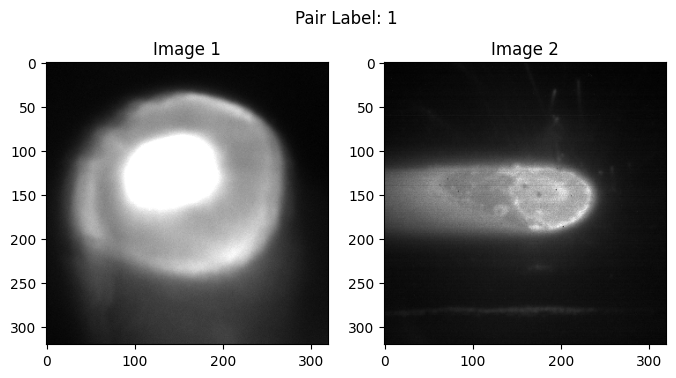

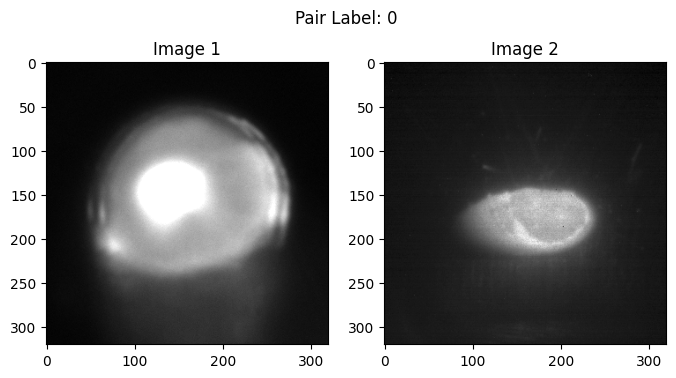

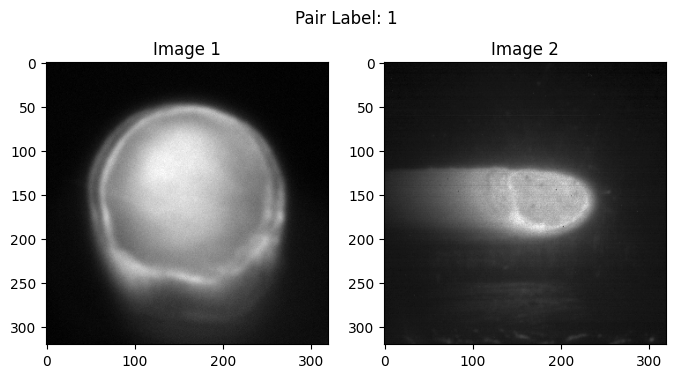

In [5]:
import matplotlib.pyplot as plt

# Verify a few pairs visually
num_samples_to_verify = 3

for i in range(num_samples_to_verify):
    sample_idx = np.random.randint(0, len(X_train))
    pair = X_train[sample_idx]
    label = y_train[sample_idx]

    # Extract images from the pair
    image1, image2 = pair[0], pair[1]

    # Display images with their corresponding label
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap='gray')
    plt.title('Image 1')

    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap='gray')
    plt.title('Image 2')

    plt.suptitle(f"Pair Label: {label[0]}")
    plt.show()


In [6]:
def create_triples(manta, xiris, y_encoded):
    # set seed
    np.random.seed(42)
        
    triples = []
    
    # Getting the indices of each class
    numclasses = len(np.unique(y_encoded))
    idx = [np.where(y_encoded==i)[0] for i in range(numclasses)]

    for idxA in range(len(y_encoded)):
        # grab the current image and label belonging to the current iteration
        currentImage = manta[idxA]
        label = y_encoded[idxA]

        # randomly pick an image that belongs to the same class label
        idxB = np.random.choice(idx[label])
        posImage = xiris[idxB]

        # grab the indices for each of the class labels not equal to the current label
        negIdx = np.where(y_encoded != label)[0]
        
        # check if the indices in negIdx are valid for xiris
        valid_negIdx = [idx for idx in negIdx if idx < len(xiris)]
        
        # randomly pick an image corresponding to a label not equal to the current label
        negImage = xiris[np.random.choice(valid_negIdx)]
        
        # prepare a negative pair of images and update our lists
        triples.append([currentImage, posImage, negImage])

        if idxA % 1000 == 0:
            print(f"Creating pairs for image {idxA}/{len(y_encoded)}, Completed {int(idxA/len(y_encoded)*100)}%")
    
    return np.array(triples) 


In [7]:
def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    model = Model(inputs=inputs, outputs=x)
    return model

# add projection head
def add_projection_head(input_shape, encoder, embedding_dim):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(embedding_dim, activation='relu')(features)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
def euclidean_distance(vecs):
    (imgA, imgB) = vecs
    
    # Calculate squared Euclidean distance
    squared_diff = tf.square(imgA - imgB)
    sum_squared_diff = tf.reduce_sum(squared_diff, axis=1, keepdims=True)
    
    # Take the square root with epsilon for numerical stability
    euclidean_dist = tf.sqrt(tf.maximum(sum_squared_diff, tf.keras.backend.epsilon()))
    
    return euclidean_dist       

def contrastiveloss(y, y_preds, margin=1):
    y = tf.cast(y, dtype=y_preds.dtype)

    # Calculate squared y_preds and margin
    y_preds_squared = tf.square(y_preds)
    margin_squared = tf.square(tf.maximum(margin - y_preds, 0))

    # Compute the loss
    return tf.reduce_mean(y * y_preds_squared + (1 - y) * margin_squared) # positive + negative loss

In [9]:
input_shape = (320, 320, 1)
embedding_dim=128
batch_size = 64
epochs = 10
learning_rate = 0.001


manta = Input(shape=input_shape)
xiris = Input(shape=input_shape)

encoder = create_encoder(input_shape)
encoder_with_projection_head = add_projection_head(input_shape, encoder, embedding_dim)
encoder_with_projection_head.summary()

manta_model = encoder_with_projection_head(manta)
xiris_model = encoder_with_projection_head(xiris)

# Calculate the distance between the two embeddings
distance = Lambda(euclidean_distance)([manta_model, xiris_model])
model = Model(inputs=[manta, xiris], outputs=distance)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 320, 320, 1)]     0         
                                                                 
 model (Functional)          (None, 369664)            55744     
                                                                 
 dense (Dense)               (None, 128)               47317120  
                                                                 
Total params: 47372864 (180.71 MB)
Trainable params: 47372864 (180.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-12-29 18:53:38.436951: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-29 18:53:38.437406: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-29 18:53:38.437552: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [10]:
model.compile(loss=contrastiveloss, optimizer=tf.keras.optimizers.Adam(learning_rate))
history = model.fit(
    [X_train[:, 0], X_train[:, 1]],
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)

Epoch 1/10


2023-12-29 18:54:01.632638: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-29 18:54:01.891105: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-29 18:54:03.038569: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-29 18:54:05.833388: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff7757fef10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-29 18:54:05.833446: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-12-29 18:54:05.848163: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703876046.076053    9528 device_compiler.h:186] 

192/192 [==============================] - 39s 160ms/step - loss: 5.0958 - val_loss: 0.0996
Epoch 2/10
192/192 [==============================] - 22s 113ms/step - loss: 0.0868 - val_loss: 0.0952
Epoch 3/10
192/192 [==============================] - 22s 114ms/step - loss: 0.0757 - val_loss: 0.0750
Epoch 4/10
192/192 [==============================] - 22s 115ms/step - loss: 0.0644 - val_loss: 0.0526
Epoch 5/10
192/192 [==============================] - 22s 114ms/step - loss: 0.0512 - val_loss: 0.0408
Epoch 6/10
192/192 [==============================] - 22s 114ms/step - loss: 0.0466 - val_loss: 0.0460
Epoch 7/10
192/192 [==============================] - 22s 114ms/step - loss: 0.0445 - val_loss: 0.0445
Epoch 8/10
192/192 [==============================] - 22s 116ms/step - loss: 0.0416 - val_loss: 0.0356
Epoch 9/10
192/192 [==============================] - 21s 111ms/step - loss: 0.0328 - val_loss: 0.0340
Epoch 10/10
192/192 [==============================] - 22s 114ms/step - loss: 0.0345

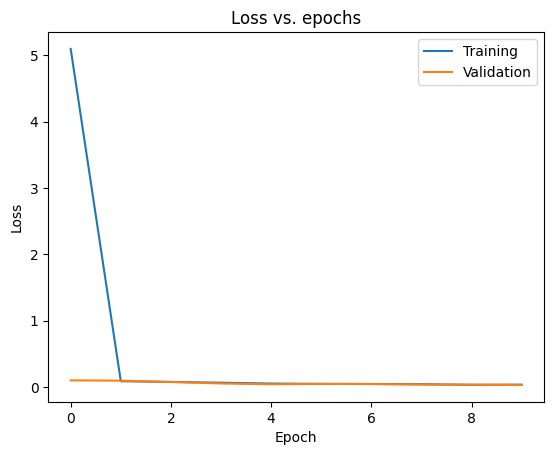

In [11]:
# visualize some results
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


In [12]:
# Evaluate the model on the test set
y_pred = model.predict([X_test[:, 0], X_test[:, 1]])
y_pred = np.squeeze(y_pred)
print("y_pred shape: ", y_pred.shape)

# Calculate the accuracy
y_pred = np.round(y_pred)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy on the test set is {accuracy:.2%}")



120/120 [==============================] - 4s 26ms/step
y_pred shape:  (3835,)
Accuracy on the test set is 37.55%
